# Minimierung der Durschlaufzeit (Flow Time) jedes Produktionsauftrags
- Es liegen Ankunftszeiten 'Arrival' vor, aber es werden speziell die frühsten Bearbeitungszeiten 'Ready Time' verwedendet, um die Kausalität zu bewahren, dass bereits angekommene Aufträge (Jobs) geplant werden können.
- Die 'Ready Time' sind auf den nächsten Tagesbeginn bzw. Schichtbeginn aufgerundete Ankunftszeiten

In [1]:
# Datenzugriff
from configs.path_manager import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.lp import flowtime_scheduling as lp_ft_schedule
from src.models.lp import flowtime_rescheduling as lp_ft_reschedule

# Simulation
from src.simulation.ProductionRollingSimulation import ProductionSimulation

# Extern
import pandas as pd

pd.set_option('display.min_rows', 12)
pd.set_option('display.max_rows', 16)

In [2]:
from src.utils.new_filter import *

In [3]:
# Harte Abbruchbedingung für die Scheduler
max_time = 60*10     # 10 min

# Simulation
simulation = ProductionSimulation(sigma = 0.25)

In [4]:
# Datei laden
basic_data_path = get_path("data", "basic")
df_routings = pd.read_csv(basic_data_path / "instance.csv")
df_routings

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
5,0,5,M05,11
...,...,...,...,...
94,9,4,M08,64
95,9,5,M09,76
96,9,6,M05,47


## I. Generierung der Job-Shop Scheduling Problems und der dazugehörigen Produktionsauftragsinformationen

In [5]:
# Generierung auf Basis von den Arbeitsplänen (Routings) und der Vorgabe bestimmten Parameter, insbesondere der Maximalauslastung (95 %)
df_jssp, df_jobs_arrivals = init.create_jobs_for_shifts(df_routings = df_routings,
                                                        routing_column = "Routing_ID", job_column = "Job",
                                                        shift_count = 2, shift_length = 1440,
                                                        u_b_mmax = 0.95, shuffle = True
                                                       )
df_jobs_arrivals

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
33,J25-0033,2,2520,2880
34,J25-0034,8,2572,2880
35,J25-0035,5,2583,2880


## Tag 1
- Am Tag 0 kommen die ersten Produktionsaufträge an, somit kann noch nichts geplant werden
- Am Tag 1 findet die initiale Planung statt

In [6]:
day_length = 1440

day_numb = 1
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [7]:
# "neue" und unerledigte Jobs
df_jobs_arrivals_current = get_current_jobs(
    df_jobs_arrivals, df_previous_not_started = None, ready_time=day_start
)
df_jobs_arrivals_current

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
1,J25-0001,6,123,1440
2,J25-0002,0,187,1440
3,J25-0003,2,231,1440
4,J25-0004,3,271,1440
5,J25-0005,1,472,1440
...,...,...,...,...
11,J25-0011,1,976,1440
12,J25-0012,2,1045,1440
13,J25-0013,3,1129,1440


In [8]:
df_jssp_current = filter_current_jssp(df_jssp, df_jobs_arrivals_current)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,8,0,M00,76
1,J25-0000,8,1,M01,69
2,J25-0000,8,2,M03,76
3,J25-0000,8,3,M05,51
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
...,...,...,...,...,...
164,J25-0016,6,4,M06,32
165,J25-0016,6,5,M05,21
166,J25-0016,6,6,M09,32


### Scheduling

In [9]:
# Scheduling
df_schedule = lp_ft_schedule.solve_jssp(
    df_jssp_current, df_jobs_arrivals_current, solver= "HiGHS",
    var_cat="Integer", msg=False, earliest_start_column = "Ready Time",
    timeLimit=max_time, gapRel= 0.05)
df_schedule

BigM: 9000

Solver-Informationen:
  Summe Flow Times        : 17343.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 1547
  Anzahl Constraints      : 2890
  Laufzeit                : ~600.13 Sekunden


,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,0,M00,76,75,1440,2006.0,2082.0
1,J25-0000,8,1,M01,69,75,1440,2370.0,2439.0
2,J25-0000,8,2,M03,76,75,1440,2646.0,2722.0
3,J25-0000,8,3,M05,51,75,1440,2722.0,2773.0
4,J25-0000,8,4,M02,85,75,1440,2773.0,2858.0
5,J25-0000,8,5,M09,11,75,1440,2881.0,2892.0
...,...,...,...,...,...,...,...,...,...
164,J25-0016,6,4,M06,32,1421,1440,1597.0,1629.0
165,J25-0016,6,5,M05,21,1421,1440,1653.0,1674.0
166,J25-0016,6,6,M09,32,1421,1440,1674.0,1706.0


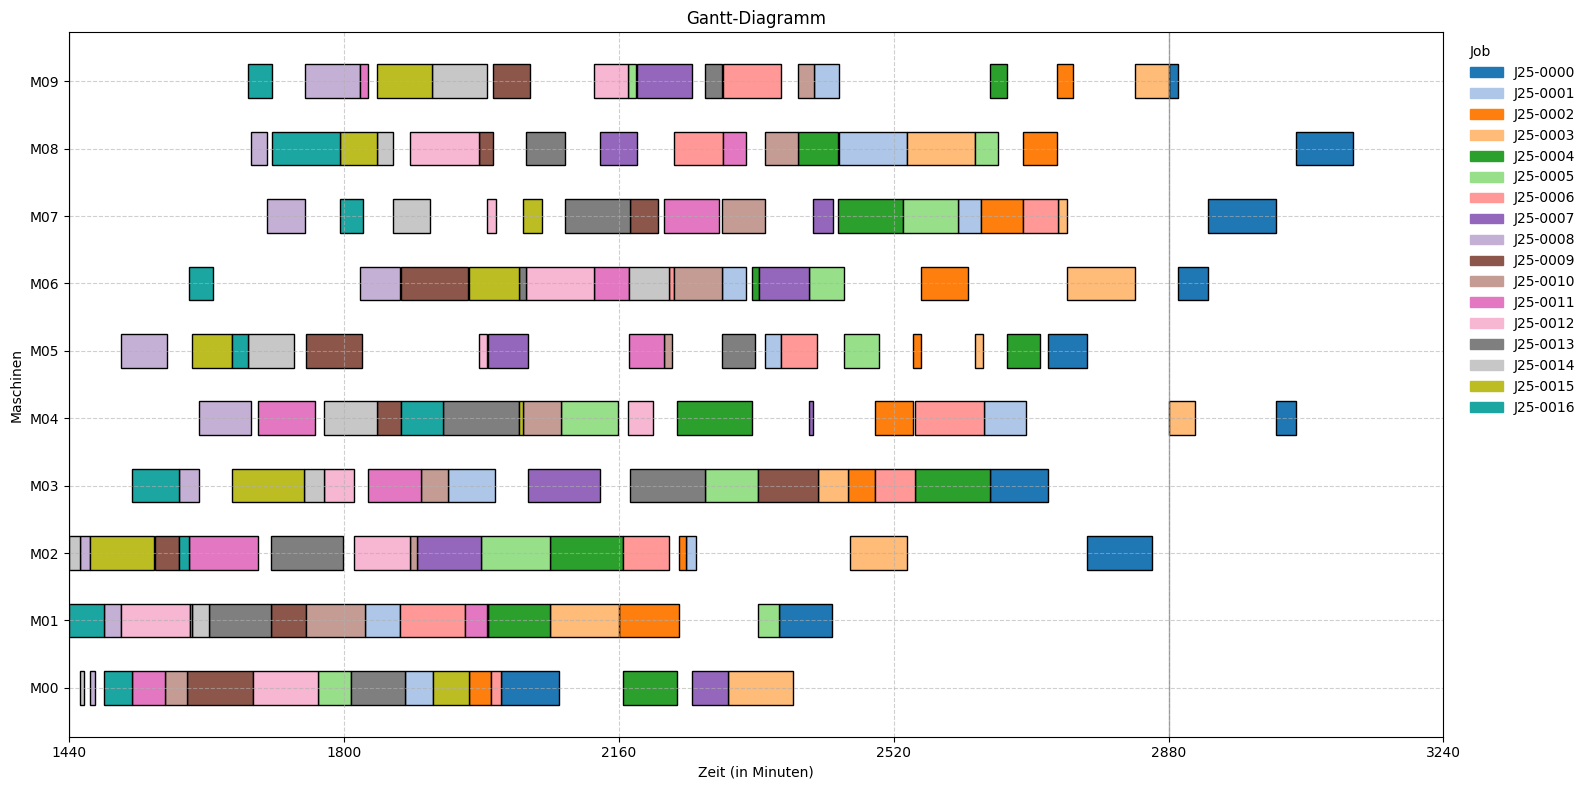

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt(df_schedule, perspective="Machine")
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)

In [11]:
df_schedule.to_csv(basic_data_path / "schedule_example_day_00.csv", index=False)

### Simulation

In [12]:
simulation.run(dframe_schedule_plan= df_schedule, start_time = day_start, end_time=day_end)

[Day 1 00:00:00] Job J25-0014 started on M02
[Day 1 00:00:00] Job J25-0016 started on M01
[Day 1 00:22:00] Job J25-0014 finished on M02 (after 22 minutes)
[Day 1 00:22:00] Job J25-0008 started on M02
[Day 1 00:22:00] Job J25-0014 started on M00
[Day 1 00:29:00] Job J25-0014 finished on M00 (after 07 minutes)
[Day 1 00:39:00] Job J25-0008 finished on M02 (after 17 minutes)
[Day 1 00:39:00] Job J25-0015 started on M02
[Day 1 00:39:00] Job J25-0008 started on M00
[Day 1 00:45:00] Job J25-0016 finished on M01 (after 45 minutes)
[Day 1 00:45:00] Job J25-0008 finished on M00 (after 06 minutes)
[Day 1 00:46:00] Job J25-0016 started on M00
[Day 1 00:46:00] Job J25-0008 started on M01
[Day 1 01:09:00] Job J25-0008 finished on M01 (after 23 minutes)
[Day 1 01:09:00] Job J25-0012 started on M01
[Day 1 01:09:00] Job J25-0008 started on M05
[Day 1 01:23:00] Job J25-0016 finished on M00 (after 37 minutes)
[Day 1 01:23:00] Job J25-0011 started on M00
[Day 1 01:23:00] Job J25-0016 started on M03
[Day 

In [13]:
df_execution = simulation.get_finished_operations_df()
df_execution

,Routing_ID,Job,Operation,Machine,Arrival,Start,Processing Time,End
0,8,J25-0000,0,M00,75,2032.0,69.0,2101.0
1,8,J25-0000,1,M01,75,2380.0,67.0,2447.0
2,8,J25-0000,2,M03,75,2751.0,68.0,2819.0
3,6,J25-0001,0,M01,123,1828.0,36.0,1864.0
4,6,J25-0001,1,M00,123,1908.0,24.0,1932.0
5,6,J25-0001,2,M03,123,1948.0,79.0,2027.0
...,...,...,...,...,...,...,...,...
154,6,J25-0016,4,M06,1421,1633.0,42.0,1675.0
155,6,J25-0016,5,M05,1421,1734.0,24.0,1758.0
156,6,J25-0016,6,M09,1421,1758.0,27.0,1785.0


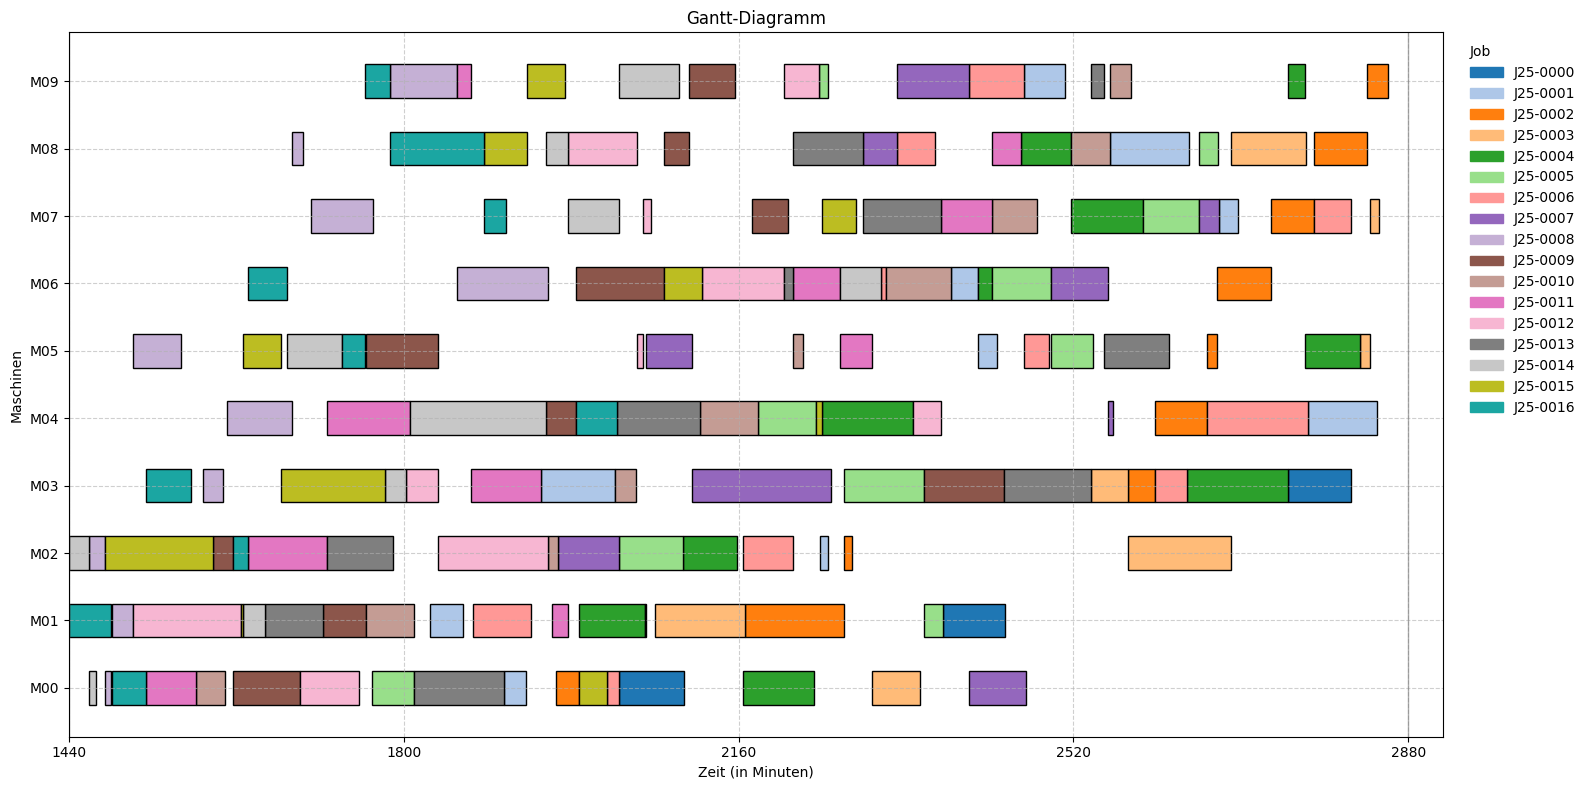

In [14]:
show.plot_gantt(df_execution, perspective="Machine")

In [15]:
df_active = simulation.get_active_operations_df()
df_active

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0000,3,M05,75,2839.0,51,57.0,2890.0,2896.0
1,J25-0003,7,M06,231,2849.0,89,64.0,2938.0,2913.0


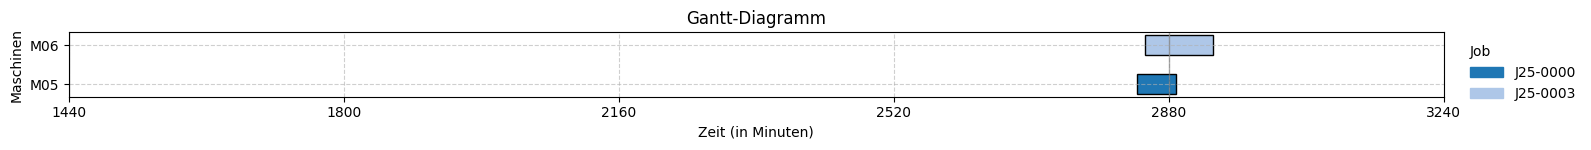

In [16]:
show.plot_gantt(df_active, perspective="Machine", duration_column="Planned Duration")

In [17]:
df_not_started = simulation.get_not_started_operations_df(df_schedule)
df_not_started

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,4,M02,85,75,1440,2773.0,2858.0
1,J25-0000,8,5,M09,11,75,1440,2881.0,2892.0
2,J25-0000,8,6,M06,40,75,1440,2892.0,2932.0
3,J25-0000,8,7,M07,89,75,1440,2932.0,3021.0
4,J25-0000,8,8,M04,26,75,1440,3021.0,3047.0
5,J25-0000,8,9,M08,74,75,1440,3047.0,3121.0
6,J25-0003,2,8,M09,45,231,1440,2836.0,2881.0
7,J25-0003,2,9,M04,33,231,1440,2881.0,2914.0


## Tag 2
- hier findet die Neuplanung statt, also das Scheduling mit bestimmter Berücksichtigung der Simulation

In [18]:
day_numb = 2
day_start = day_length*day_numb
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


In [19]:
df_not_started["Job"].unique()

array(['J25-0000', 'J25-0003'], dtype=object)

In [21]:
# "neue" und unerledigte Jobs
df_jobs_arrivals_current = get_current_jobs(df_jobs_arrivals, df_not_started, ready_time=day_start)
df_jobs_arrivals_current

,Job,Routing_ID,Arrival,Ready Time
0,J25-0000,8,75,1440
3,J25-0003,2,231,1440
17,J25-0017,7,1766,2880
18,J25-0018,8,1818,2880
19,J25-0019,9,1823,2880
20,J25-0020,1,1833,2880
...,...,...,...,...
33,J25-0033,2,2520,2880
34,J25-0034,8,2572,2880
35,J25-0035,5,2583,2880


In [22]:
df_jssp_current = filter_current_jssp(
    df_jssp = df_jssp,
    df_jobs_times_current = df_jobs_arrivals_current,
    exclusion_dataframes_list = [df_active, df_execution]
)
df_jssp_current

,Job,Routing_ID,Operation,Machine,Processing Time
4,J25-0000,8,4,M02,85
5,J25-0000,8,5,M09,11
6,J25-0000,8,6,M06,40
7,J25-0000,8,7,M07,89
8,J25-0000,8,8,M04,26
9,J25-0000,8,9,M08,74
...,...,...,...,...,...
384,J25-0038,3,4,M06,9
385,J25-0038,3,5,M08,52
386,J25-0038,3,6,M07,85


### a) einfache Neuplanung
- berücksichtigt lediglich die aktiven Arbeitsgänge (Operationen)

In [23]:
df_schedule_simple = lp_ft_reschedule.solve_jssp_with_fixed_ops(df_jssp_current, df_jobs_arrivals_current,
                                                           df_active, reschedule_start = day_start,
                                                           solver= "HiGHS", msg=False,
                                                           timeLimit=max_time, gapRel= 0.10)
df_schedule_simple

BigM: 15000

Solver-Informationen:
  Summe Flow Times        : 51307.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2785
  Anzahl Constraints      : 5318
  Laufzeit                : ~601.45 Sekunden


,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J25-0000,8,4,75,M02,2964.0,85.0,2974.0,3049.0
1,J25-0000,8,5,75,M09,3049.0,11.0,2985.0,3060.0
2,J25-0000,8,6,75,M06,3060.0,40.0,3025.0,3100.0
3,J25-0000,8,7,75,M07,3100.0,89.0,3114.0,3189.0
4,J25-0000,8,8,75,M04,3189.0,26.0,3140.0,3215.0
5,J25-0000,8,9,75,M08,3215.0,74.0,3214.0,3289.0
...,...,...,...,...,...,...,...,...,...
222,J25-0038,3,4,2815,M06,4568.0,9.0,1762.0,4577.0
223,J25-0038,3,5,2815,M08,4624.0,52.0,1861.0,4676.0
224,J25-0038,3,6,2815,M07,4676.0,85.0,1946.0,4761.0


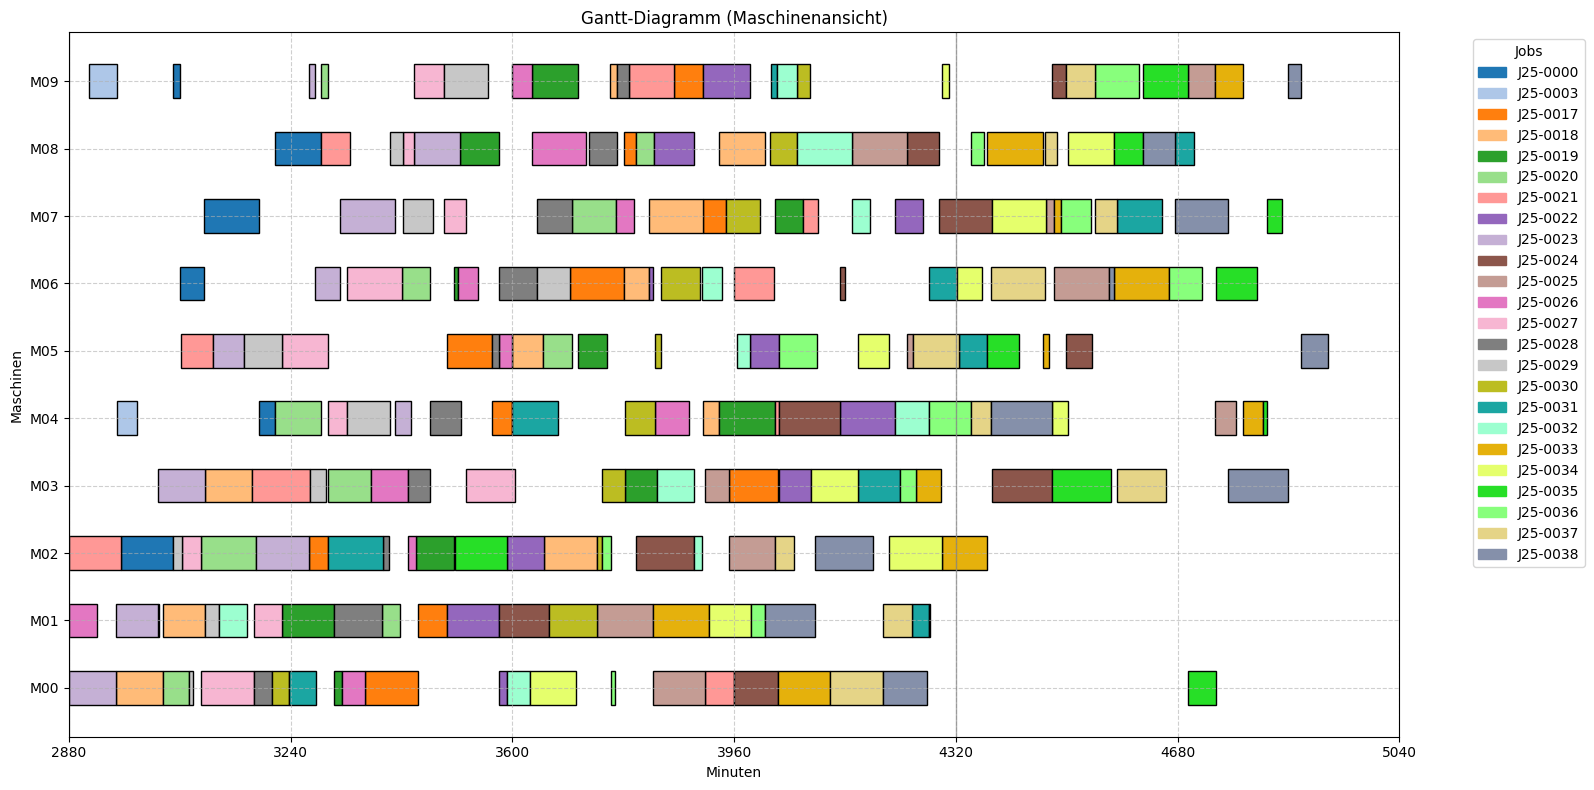

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [24]:
df_temp =  df_schedule_simple

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

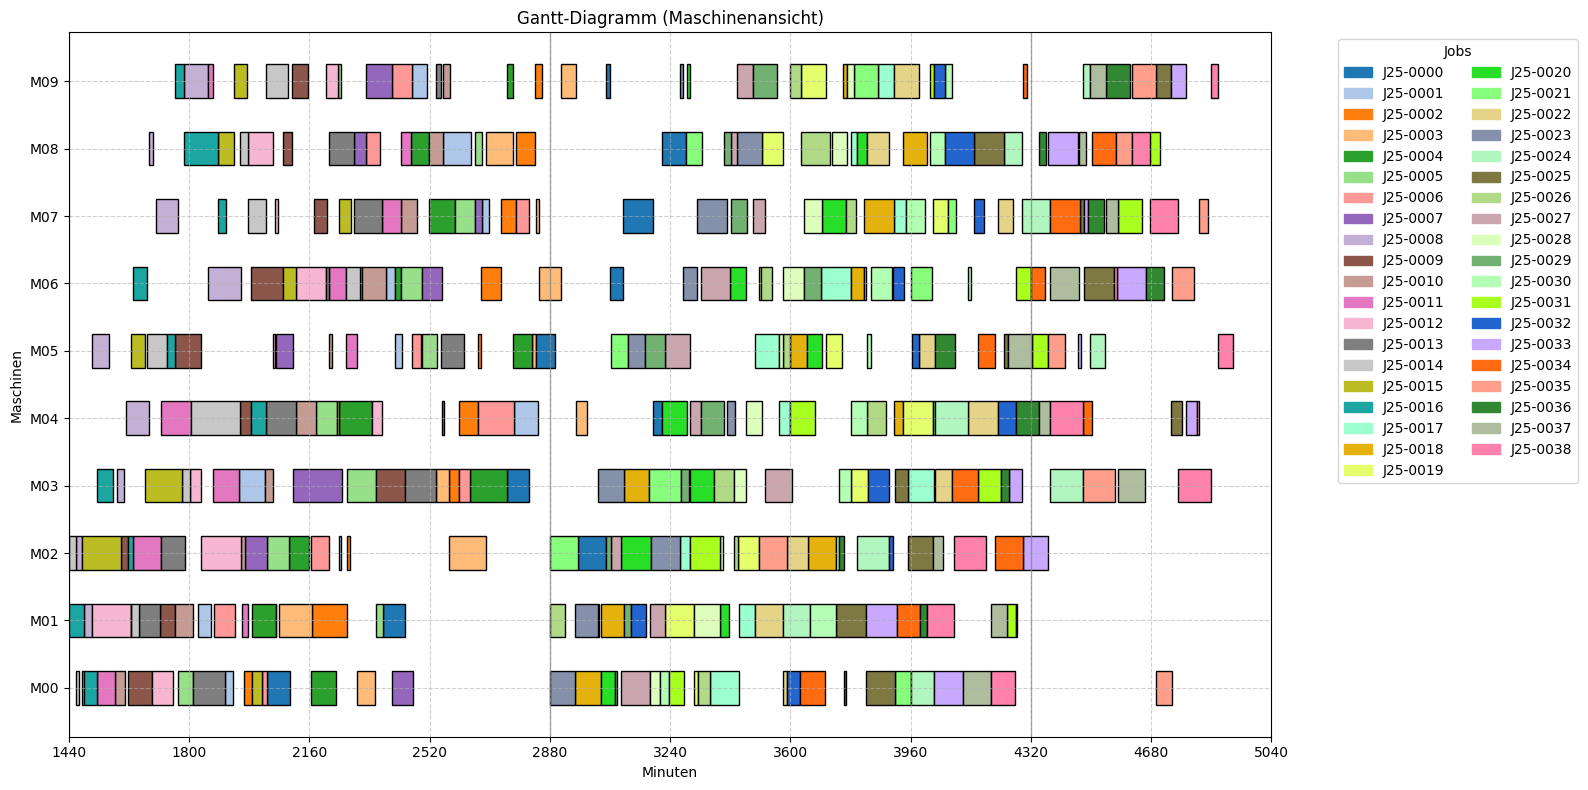

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [25]:
df_reschedule = df_schedule_simple

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### b) Neuplanung mit zusätzlich Minimierung der Planabweichung für die zuvor geplante Arbeitsgänge

In [26]:
df_schedule_devpen = lp_ft_reschedule.solve_jssp_with_devpen(df_jssp_current, df_jobs_arrivals_current, df_active,
                                                             df_original_plan = df_schedule, r = 0.60, # 60% Flowtime, 40% Abweichung
                                                             reschedule_start = day_start, solver= "HiGHS",
                                                             msg=False, timeLimit=max_time, gapRel= 0.02)
df_schedule_devpen

BigM: 15000

Solver-Informationen:
  Zielfunktionswert       : 31586.0
  Solver-Status           : Optimal
  Anzahl Variablen        : 2793
  Anzahl Constraints      : 5334
  Laufzeit                : ~600.26 Sekunden


,Job,Routing_ID,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,J25-0000,8,4,75,M02,2911.0,85.0,2921.0,2996.0
1,J25-0000,8,5,75,M09,2996.0,11.0,2932.0,3007.0
2,J25-0000,8,6,75,M06,3007.0,40.0,2972.0,3047.0
3,J25-0000,8,7,75,M07,3047.0,89.0,3061.0,3136.0
4,J25-0000,8,8,75,M04,3136.0,26.0,3087.0,3162.0
5,J25-0000,8,9,75,M08,3212.0,74.0,3211.0,3286.0
...,...,...,...,...,...,...,...,...,...
222,J25-0038,3,4,2815,M06,4788.0,9.0,1982.0,4797.0
223,J25-0038,3,5,2815,M08,4797.0,52.0,2034.0,4849.0
224,J25-0038,3,6,2815,M07,4881.0,85.0,2151.0,4966.0


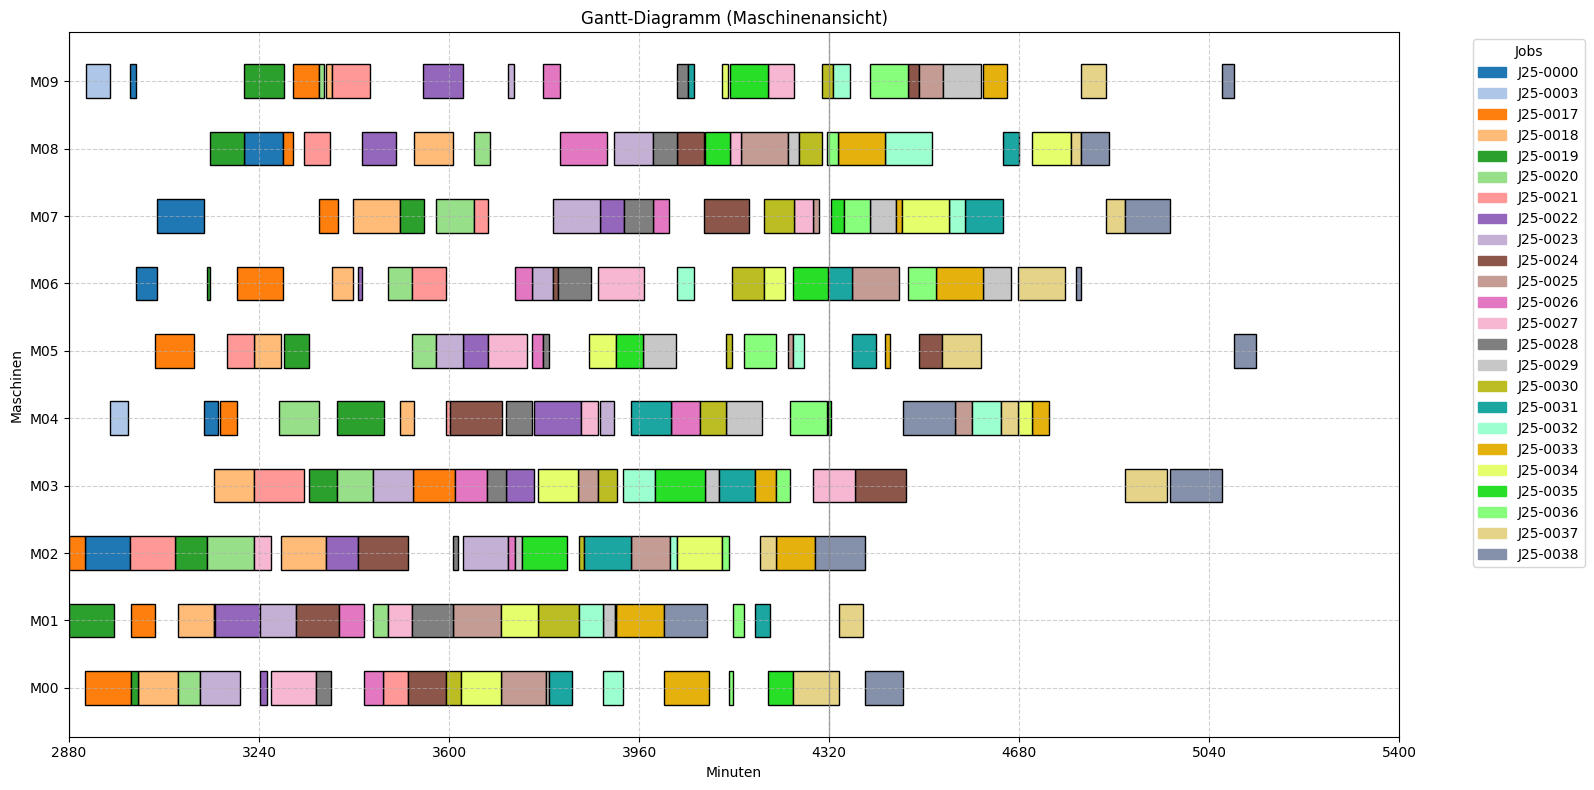

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [27]:
df_temp =  df_schedule_devpen

show.plot_gantt_machines(df_temp)
check.is_machine_conflict_free(df_temp)
check.is_operation_sequence_correct(df_temp)
check.is_job_timing_correct(df_temp)
check.is_start_correct(df_temp)

#### Check der Bedingungen des kombinierten Datensatzes aus den Simulationsdaten mit dem neuen Schedule

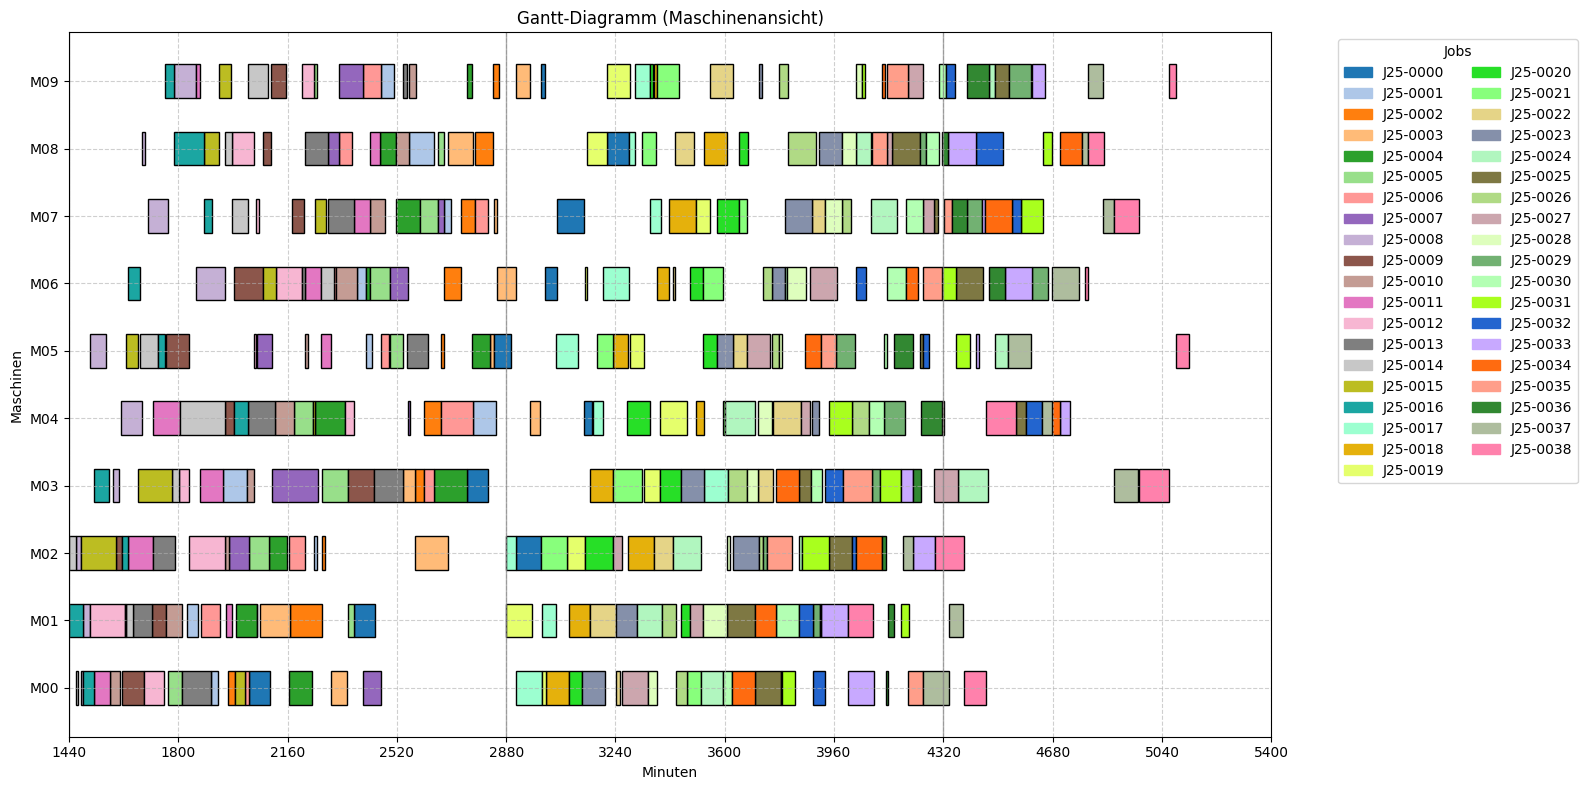

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [28]:
df_reschedule = df_schedule_devpen

columns = ["Job", "Operation", "Machine", "Arrival", "Start", "Processing Time", "End"]
df_combined = pd.concat([df_execution, df_active[columns], df_reschedule[columns]], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)


### Simulation

In [29]:
simulation.run(dframe_schedule_plan = df_schedule_devpen, start_time = day_start, end_time = day_end)

[Day 2 00:00:00] Job J25-0000, Operation 3 resumed with 16.00 min
[Day 2 00:00:00] Job J25-0003, Operation 7 resumed with 33.00 min
[Day 2 00:00:00] Job J25-0017 started on M02
[Day 2 00:00:00] Job J25-0019 started on M01
[Day 2 00:16:00] Job J25-0000 finished on M05 (after 16 minutes)
[Day 2 00:33:00] Job J25-0003 finished on M06 (after 33 minutes)
[Day 2 00:33:00] Job J25-0003 started on M09
[Day 2 00:44:00] Job J25-0017 finished on M02 (after 44 minutes)
[Day 2 00:44:00] Job J25-0000 started on M02
[Day 2 00:44:00] Job J25-0017 started on M00
[Day 2 01:09:00] Job J25-0003 finished on M09 (after 36 minutes)
[Day 2 01:18:00] Job J25-0003 started on M04
[Day 2 01:24:00] Job J25-0019 finished on M01 (after 84 minutes)
[Day 2 01:46:00] Job J25-0003 finished on M04 (after 28 minutes)
[Day 2 01:49:00] Job J25-0000 finished on M02 (after 65 minutes)
[Day 2 01:50:00] Job J25-0017 finished on M00 (after 66 minutes)
[Day 2 01:56:00] Job J25-0021 started on M02
[Day 2 01:56:00] Job J25-0000 sta

In [30]:
df_execution2 = simulation.get_finished_operations_df()
df_execution2

,Job,Operation,Machine,Arrival,Start,Processing Time,End,Routing_ID
0,J25-0000,3,M05,75,2839.0,57.0,2896.0,NaN
1,J25-0000,4,M02,75,2924.0,65.0,2989.0,8.0
2,J25-0000,5,M09,75,2996.0,15.0,3011.0,8.0
3,J25-0000,6,M06,75,3011.0,30.0,3041.0,8.0
4,J25-0000,7,M07,75,3047.0,82.0,3129.0,8.0
5,J25-0000,8,M04,75,3136.0,23.0,3159.0,8.0
...,...,...,...,...,...,...,...,...
159,J25-0036,1,M00,2590,4180.0,6.0,4186.0,4.0
160,J25-0036,2,M01,2590,4186.0,29.0,4215.0,4.0
161,J25-0036,3,M05,2590,4215.0,67.0,4282.0,4.0


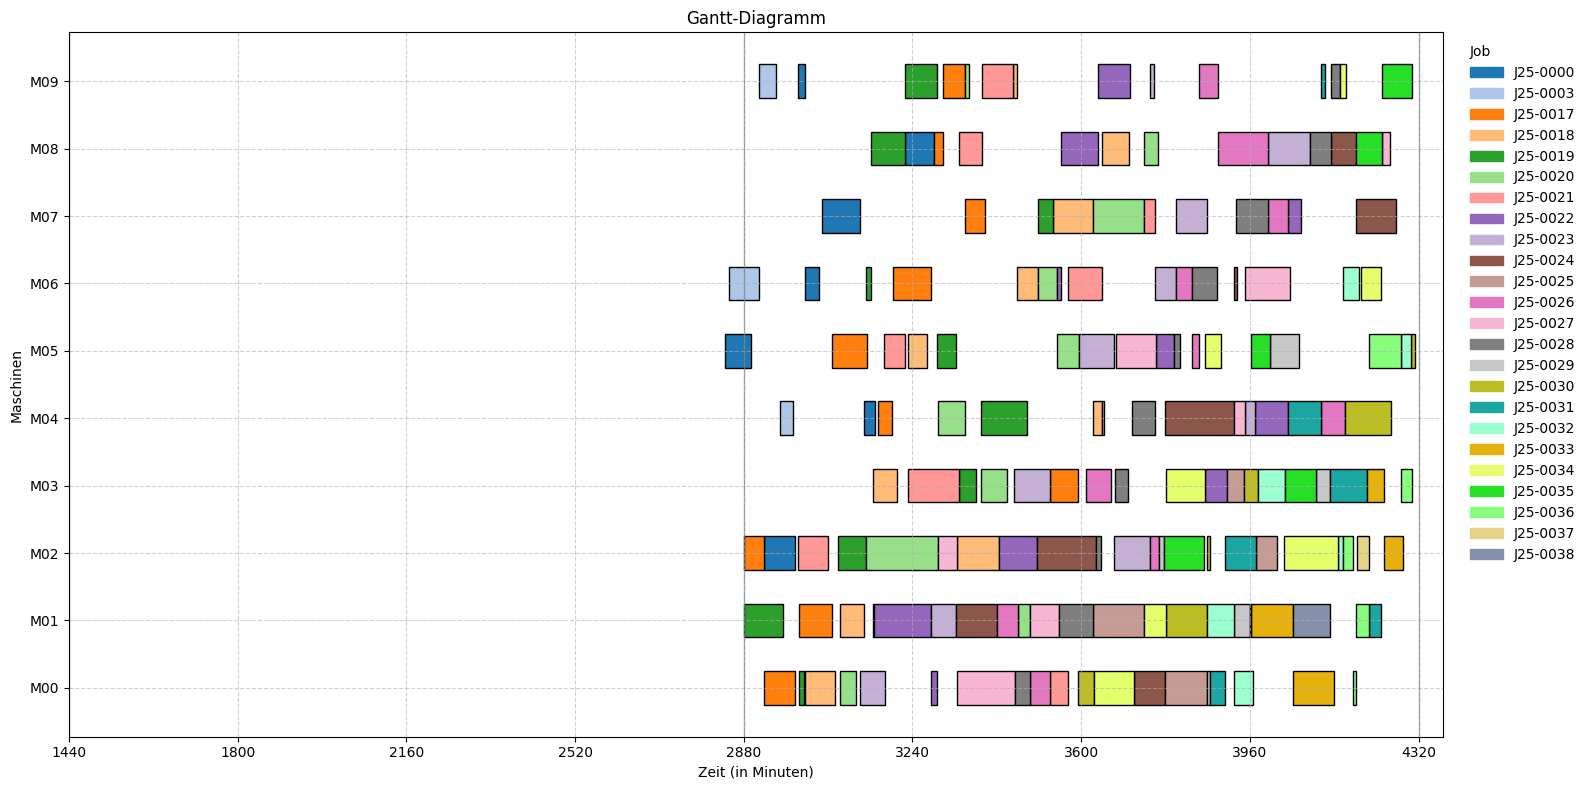

In [31]:
show.plot_gantt(df_execution2, perspective="Machine")

In [32]:
df_active2 = simulation.get_active_operations_df()
df_active2

,Job,Operation,Machine,Arrival,Start,Planned Duration,Processing Time,Expected End,End
0,J25-0025,4,M08,2015,4259.0,90.0,110.0,4349.0,4369.0
1,J25-0027,7,M09,2157,4306.0,48.0,52.0,4354.0,4358.0
2,J25-0029,5,M04,2179,4260.0,69.0,71.0,4329.0,4331.0
3,J25-0030,6,M06,2191,4313.0,62.0,78.0,4375.0,4391.0
4,J25-0037,1,M00,2654,4252.0,86.0,103.0,4338.0,4355.0
5,J25-0038,1,M02,2815,4293.0,95.0,90.0,4388.0,4383.0


In [33]:
df_not_started2 = simulation.get_not_started_operations_df(df_schedule)
df_not_started2

,Job,Routing_ID,Operation,Machine,Processing Time,Arrival,Ready Time,Start,End
0,J25-0000,8,0,M00,76,75,1440,2006.0,2082.0
1,J25-0000,8,1,M01,69,75,1440,2370.0,2439.0
2,J25-0000,8,2,M03,76,75,1440,2646.0,2722.0
3,J25-0001,6,0,M01,46,123,1440,1828.0,1874.0
4,J25-0001,6,1,M00,37,123,1440,1880.0,1917.0
5,J25-0001,6,2,M03,61,123,1440,1937.0,1998.0
...,...,...,...,...,...,...,...,...,...
154,J25-0016,6,4,M06,32,1421,1440,1597.0,1629.0
155,J25-0016,6,5,M05,21,1421,1440,1653.0,1674.0
156,J25-0016,6,6,M09,32,1421,1440,1674.0,1706.0


#### Check der Bedingungen des kombinierten Datensatzes aus den beiden Simulationsdaten

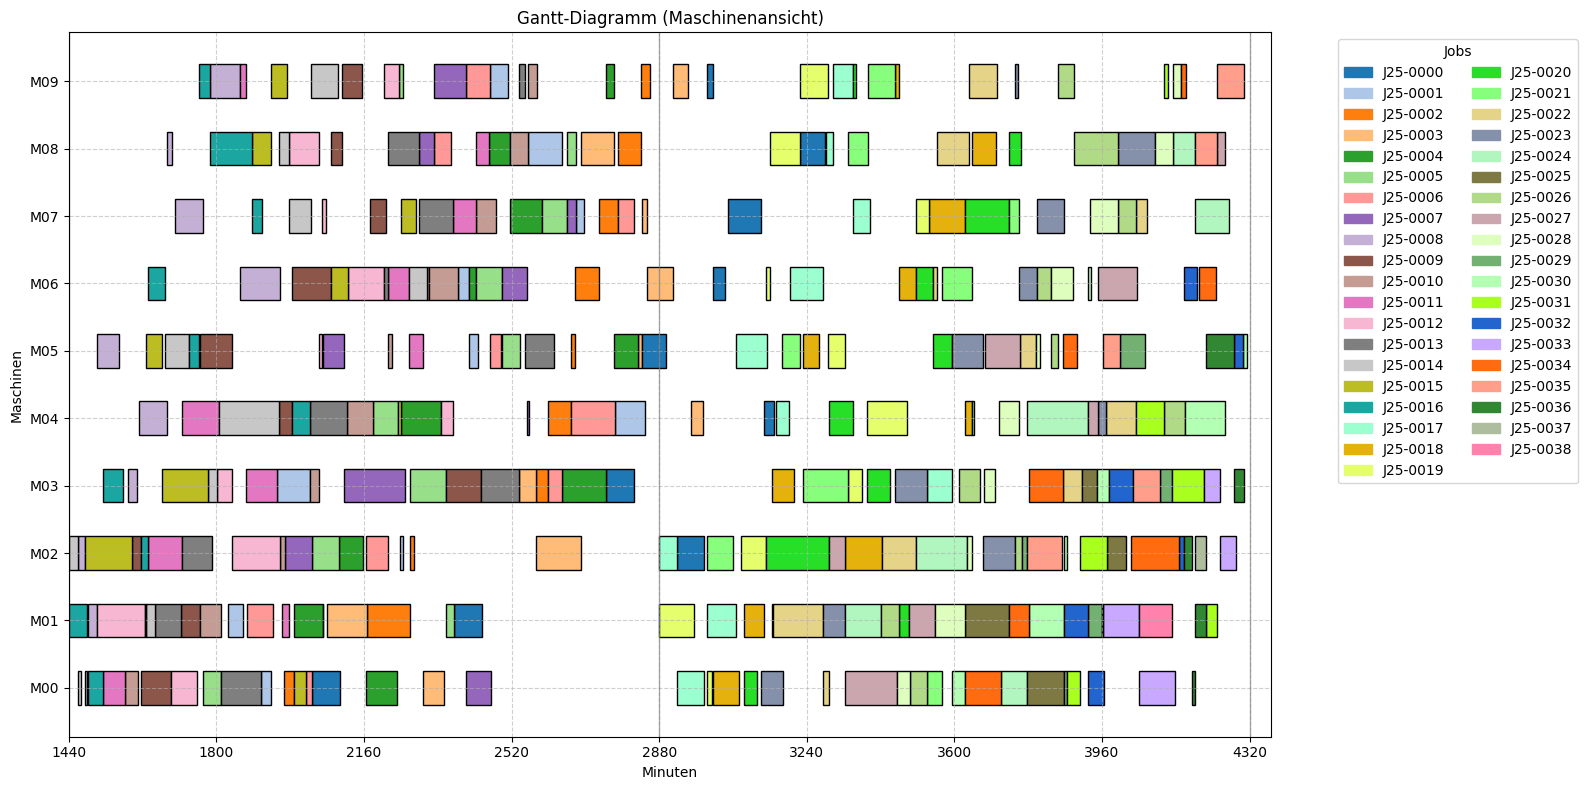

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [34]:
df_combined = pd.concat([df_execution, df_execution2], ignore_index=True)
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)